170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)


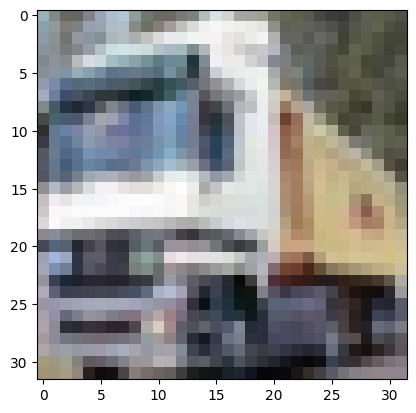

Epoch 1/100
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3716 - loss: 1.8037
Epoch 1: val_loss improved from inf to 1.26402, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 27ms/step - accuracy: 0.3717 - loss: 1.8034 - val_accuracy: 0.5680 - val_loss: 1.2640 - learning_rate: 0.0010
Epoch 2/100
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5798 - loss: 1.2239
Epoch 2: val_loss improved from 1.26402 to 1.14615, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.5798 - loss: 1.2239 - val_accuracy: 0.6386 - val_loss: 1.1461 - learning_rate: 0.0010
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6583 - loss: 1.0391
Epoch 3: val_loss improved from 1.14615 to 0.87582, saving model to best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.6583 - loss: 1.0391 - val_accuracy: 0.7318 - val_loss: 0.8758 - learning_rate: 0.0010
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0

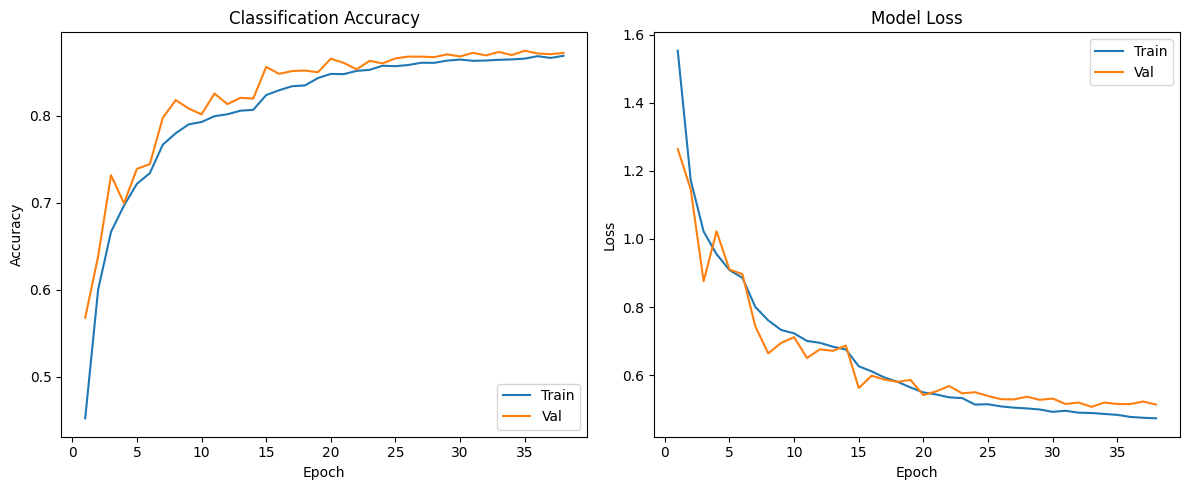

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


<Figure size 1000x800 with 0 Axes>

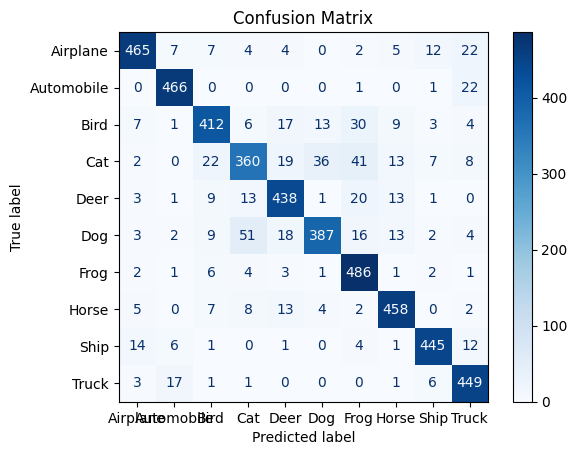

In [ ]:
import warnings


warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="keras.src.trainers.data_adapters.py_dataset_adapter",
)
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Display a sample image
plt.imshow(x_train[1])
plt.show()


# Normalize pixel values
def normalize(x):
    x = x.astype("float32") / 255.0
    return x


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)

# Split test set into test and validation sets
x_test, x_val, y_test, y_val = train_test_split(
    x_test, y_test, test_size=0.5, random_state=0
)

# Normalize data
x_train = normalize(x_train)
x_test = normalize(x_test)
x_val = normalize(x_val)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)

# Fit data augmentation
datagen.fit(x_train)


# Function to train and evaluate model
def results(model, epochs=100):
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.001,
        restore_best_weights=True,
        verbose=1,
    )

    checkpoint = ModelCheckpoint(
        "best_model.keras", monitor="val_loss", save_best_only=True, verbose=1
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
    )

    r = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),
        epochs=epochs,
        validation_data=(x_val, y_val),
        verbose=1,
        callbacks=[early_stopping, checkpoint, lr_scheduler],
    )

    # Evaluate model
    acc = model.evaluate(x_test, y_test)
    print("Test set loss:", acc[0])
    print("Test set accuracy:", acc[1] * 100)

    # Plot accuracy and loss
    epoch_range = range(1, len(r.history["accuracy"]) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, r.history["accuracy"])
    plt.plot(epoch_range, r.history["val_accuracy"])
    plt.title("Classification Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Val"], loc="lower right")

    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, r.history["loss"])
    plt.plot(epoch_range, r.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Val"], loc="upper right")

    plt.tight_layout()
    plt.show()

    # Confusion matrix
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[
            "Airplane",
            "Automobile",
            "Bird",
            "Cat",
            "Deer",
            "Dog",
            "Frog",
            "Horse",
            "Ship",
            "Truck",
        ],
    )
    plt.figure(figsize=(10, 8))
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()


# Define the CNN model
weight_decay = 1e-4
model = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(
        32,
        (3, 3),
        activation="relu",
        padding="same",
        kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
    ),
    BatchNormalization(),
    Conv2D(
        32,
        (3, 3),
        activation="relu",
        padding="same",
        kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
    ),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(
        64,
        (3, 3),
        activation="relu",
        padding="same",
        kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
    ),
    BatchNormalization(),
    Conv2D(
        64,
        (3, 3),
        activation="relu",
        padding="same",
        kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
    ),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(
        128,
        (3, 3),
        activation="relu",
        padding="same",
        kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
    ),
    BatchNormalization(),
    Conv2D(
        128,
        (3, 3),
        activation="relu",
        padding="same",
        kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
    ),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax"),
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train and evaluate
results(model, epochs=100)

# Save the final model
model.save("model.keras")
